# Detecting seasonality <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[DEA Waterbodies](https://knowledge.dea.ga.gov.au/data/product/dea-waterbodies-landsat)


## Description

We often want to analyse a time series to detect long-term trends or events. Time series that span multiple months will have seasonal effects: for example, northern Australia is much wetter in summer due to monsoons. This seasonality may impact our ability to detect the trends or events we are interested in. This notebook provides a few different ways to detect seasonality and check whether deseasonalised data have been correctly deseasonalised. We will look at a seasonal waterbody time series as an example.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import calendar
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
import pandas as pd
import scipy.stats
import statsmodels.tsa.seasonal as sm_seasonal
import statsmodels.tsa.stattools as tsa_stats
import shapely

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.waterbodies import get_waterbody, get_time_series


### Analysis parameters

Choose a waterbody to analyse:

In [2]:
geohash = "r1twfjubj_v3"  # Lake Tyrrell

## Load the waterbody time series

In [3]:
ts = get_time_series(geohash)

<Axes: xlabel='date'>

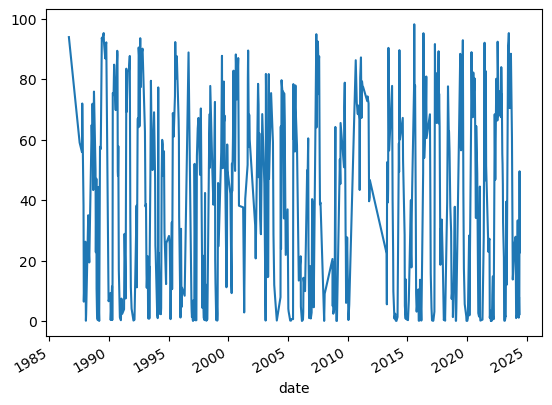

In [4]:
ts.pc_wet.plot()

Then resample the time series to weekly and interpolate. Having a consistent gap between observations makes analysis of time series much easier. In particular, this notebook won't work without an evenly spaced time series.

Here, we interpolate with `pandas` since our time series is in a `pandas.DataFrame`; `xarray` has a similar interpolate method that can interpolate over `xarray.DataArray`.

In [5]:
ts = ts.resample("1W").mean().interpolate(method="time").pc_wet

In [6]:
assert not ts.isnull().any()

Deseasonalise it for comparison.

In [7]:
decomposition = sm_seasonal.seasonal_decompose(ts + 1, model="multiplicative")

In [8]:
ts_deseasonal = decomposition.trend + decomposition.resid - 1

In [9]:
ts_deseasonal = ts_deseasonal[pd.notnull(ts_deseasonal)]

## Autocorrelation

The autocorrelation function (ACF) shows how correlated lagged data are. Seasonal data are highly correlated with a lag of one year. Let's compute the ACF for both our waterbody time series and the deseasonalised waterbody time series.

In [10]:
acf = tsa_stats.acf(ts, nlags=52 * 3, fft=True)
acf_deseasonal = tsa_stats.acf(ts_deseasonal, nlags=52 * 3, fft=True)

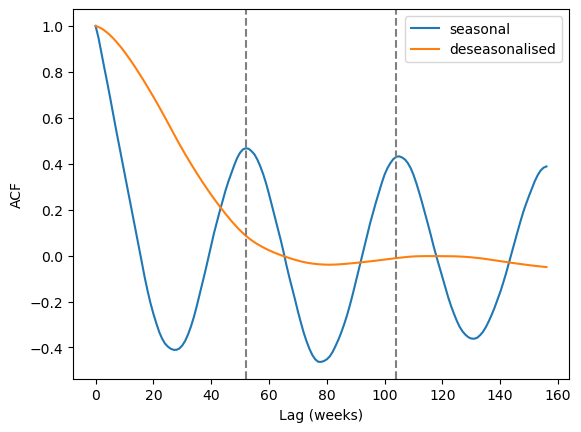

In [11]:
plt.plot(acf, label="seasonal")
plt.plot(acf_deseasonal, label="deseasonalised")
plt.xlabel("Lag (weeks)")
plt.ylabel("ACF")
for i in range(1, 3):
    plt.axvline(52 * i, c="grey", linestyle="--")
plt.legend();

The seasonal peaks are clearly visible at the 52 and 104 week marks for the seasonal data, while no such peaks can be seen for the deseasonalised data.

## Angular visualisation

A date can be thought of as an angle (the angle of the Earth's position around the sun). In this way we can project the time series into polar coordinates. Non-seasonal data will circle around the origin and be a perfect circle on average; seasonal data will be offset from the origin. Long-term trends may show as spirals.

In [12]:
time_angle = 2 * np.pi * ts.index.dayofyear / 365.25

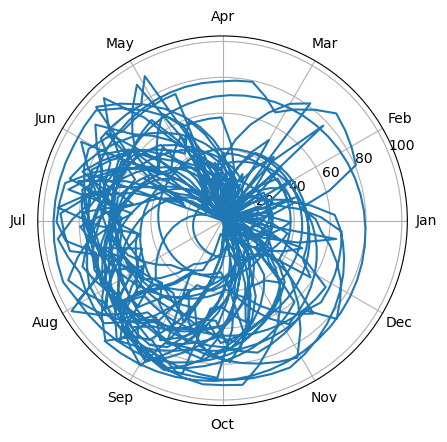

In [13]:
ax = plt.subplot(projection="polar")
ax.plot(time_angle, ts)
ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
ax.set_xticklabels(list(calendar.month_abbr)[1:]);

We can also bin the data by angle to make the circle easier to see.

In [14]:
n_bins = 52
binned_mean = scipy.stats.binned_statistic(time_angle, ts, bins=n_bins)
binned_stdev = scipy.stats.binned_statistic(
    time_angle, ts, bins=n_bins, statistic="std"
)

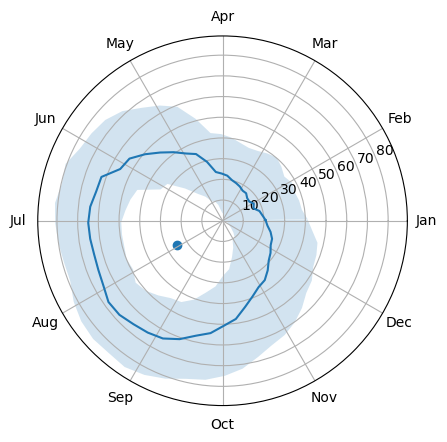

In [15]:
ax = plt.subplot(projection="polar")
mean = np.resize(binned_mean.statistic, n_bins + 1)
stdev = np.resize(binned_stdev.statistic, n_bins + 1)
# np.resize is different to ndarray.resize!
ax.plot(binned_mean.bin_edges, mean)
ax.fill_between(
    binned_mean.bin_edges, np.clip(mean - stdev, 0, None), mean + stdev, alpha=0.2
)

# Get the centre of the circle so we can plot that too:
proj = ax.transData.transform(np.stack([binned_mean.bin_edges, mean]).T)
polygon = shapely.geometry.Polygon(proj)
reproj = ax.transData.inverted().transform((polygon.centroid.x, polygon.centroid.y))
plt.scatter(*reproj, c="C0")

ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
ax.set_xticklabels(list(calendar.month_abbr)[1:]);

This waterbody is wetter from May to September and drier from November to April. The centre of the circle is clearly offset. Let's compare to the deseasonalised:

In [16]:
time_angle_deseasonal = 2 * np.pi * ts_deseasonal.index.dayofyear / 365.25

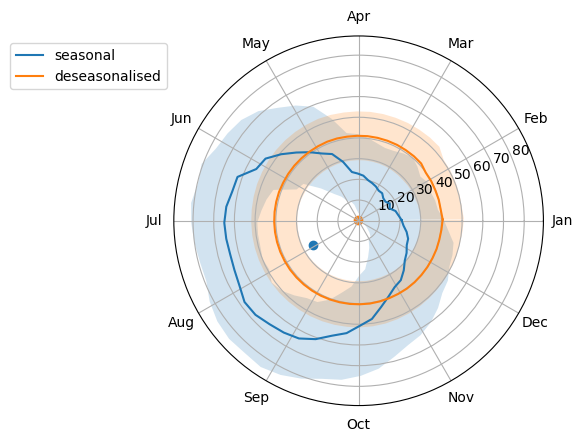

In [17]:
binned_mean_deseasonal = scipy.stats.binned_statistic(
    time_angle_deseasonal, ts_deseasonal, bins=n_bins
)
binned_stdev_deseasonal = scipy.stats.binned_statistic(
    time_angle_deseasonal, ts_deseasonal, bins=n_bins, statistic="std"
)

ax = plt.subplot(projection="polar")
ax.plot(binned_mean.bin_edges, mean, label="seasonal")
ax.fill_between(
    binned_mean.bin_edges, np.clip(mean - stdev, 0, None), mean + stdev, alpha=0.2
)
plt.scatter(*reproj, c="C0")

mean_deseasonal = np.resize(binned_mean_deseasonal.statistic, n_bins + 1)
stdev_deseasonal = np.resize(binned_stdev_deseasonal.statistic, n_bins + 1)
# np.resize is different to ndarray.resize!
ax.plot(binned_mean_deseasonal.bin_edges, mean_deseasonal, label="deseasonalised")
ax.fill_between(
    binned_mean_deseasonal.bin_edges,
    np.clip(mean_deseasonal - stdev_deseasonal, 0, None),
    mean_deseasonal + stdev_deseasonal,
    alpha=0.2,
)

proj_deseasonal = ax.transData.transform(
    np.stack([binned_mean_deseasonal.bin_edges, mean_deseasonal]).T
)
polygon_deseasonal = shapely.geometry.Polygon(proj_deseasonal)
reproj_deseasonal = ax.transData.inverted().transform(
    (polygon_deseasonal.centroid.x, polygon_deseasonal.centroid.y)
)
plt.scatter(*reproj_deseasonal, c="C1")

ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
ax.set_xticklabels(list(calendar.month_abbr)[1:])

ax.legend(bbox_to_anchor=(0, 1));

The deaseasonalised data are much more circular and the centre is very close to the origin.

We can convert this into a numerical measure to help determine how seasonal the data are (which would be useful for analysis en masse). One way to do this is to compute the Polsby-Popper score, which is the ratio of the area to the squared perimeter, multiplied by $4\pi$. This is a measure of compactness and a circle is a maximally compact shape.

In [18]:
pp = 4 * np.pi * polygon.area / polygon.exterior.length ** 2
pp_deseasonal = (
    4 * np.pi * polygon_deseasonal.area / polygon_deseasonal.exterior.length ** 2
)

In [19]:
print("Seasonal Polsby-Popper:", round(pp, 2))
print("Deseasonalised Polsby-Popper:", round(pp_deseasonal, 2))

Seasonal Polsby-Popper: 0.93
Deseasonalised Polsby-Popper: 0.97


The closer we are to 1, the more circular the data.

Circularity alone doesn't tell us that we have non-seasonal data. The circle also needs to be centred. We can measure the distance from the origin:

In [20]:
print("Seasonal offset:", reproj[1])
print("Deseasonalised offset:", reproj_deseasonal[1])

Seasonal offset: 24.780557000298504
Deseasonalised offset: 0.4586400660396238


The closer we are to zero, the less offset from the origin our data are.

## Seasonal subseries plot

A seasonal subseries plot groups data by period (in this case there are 12 months in the year, so the period is 12), and then plots each group. This can help detect both seasonality and change in seasonality over time.

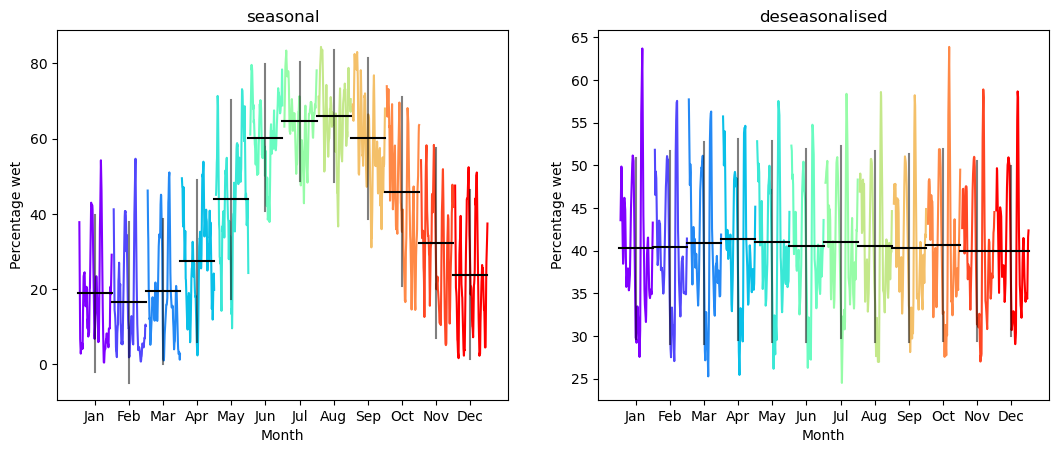

In [21]:
plt.figure(figsize=(2 * 6.4, 4.8))
titles = ["seasonal", "deseasonalised"]
monthly_means = [[], []]
for i, ts_ in enumerate([ts, ts_deseasonal]):
    plt.subplot(1, 2, i + 1)
    colours = matplotlib.cm.rainbow(np.linspace(0, 1, 12))
    for month, t in ts_.groupby(ts_.index.month):
        plt.plot(
            month + np.linspace(0, 1, len(t)),
            t.rolling(10).mean(),
            c=colours[month - 1],
        )
        plt.plot([month, month + 1], [t.mean()] * 2, c="k")
        plt.plot(
            [month + 0.5] * 2,
            [t.mean() - t.std(), t.mean() + t.std()],
            c="k",
            alpha=0.5,
        )
        monthly_means[i].append(t.mean())
    plt.xlabel("Month")
    plt.xticks(np.arange(1.5, 13.5), calendar.month_abbr[1:])
    plt.ylabel("Percentage wet")
    plt.title(titles[i])

The seasonal plot again shows very clear maxima during winter and minima during summer. The deseasonalised plot has no such pattern, and the differences between monthly means are within standard error.

We can also aggregate this plot into a single number representing seasonality. There are many ways to do this &mdash; any measure of how deviant the means are from a horizontal line would work, for example. One such measure would be the average deviation from the mean:

In [22]:
monthly_means = np.array(monthly_means)

In [23]:
mad = abs(monthly_means - monthly_means.mean(axis=1, keepdims=True)).mean(axis=1)

In [24]:
print("Seasonal mean average deviation:", mad[0].round(2))
print("Deseasonalised mean average deviation:", mad[1].round(2))

Seasonal mean average deviation: 16.86
Deseasonalised mean average deviation: 0.35


The closer to zero, the less seasonal the data are.

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [GitHub](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** July 2024

## Tags
<!-- Browse all available tags on the DEA User Guide's [Tags Index](https://knowledge.dea.ga.gov.au/genindex/) -->